# Logistic Regression

## Step 1: Create the Spark Session Object

We start the Jupyter Notebook and import `SparkSession` and create a new 
`SparkSession` object to use Spark

In [1]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('log_reg').getOrCreate()

## Step 2: Read the Dataset

We then load and read the dataset within Spark using Dataframe. We have 
to make sure we have opened the PySpark from the same directory folder 
where the dataset is available or else we have to mention the directory path 
of the data folder

In [4]:
df = spark.read.csv('Log_Reg_dataset.csv', inferSchema=True, header=True)

## Step 3: Exploratory Data Analysis

In this section, we drill deeper into the dataset by viewing the dataset 
and validating the shape of the it and various statistical measures of the 
variables

In [5]:
print((df.count(), len(df.columns)))

(20000, 6)


In [6]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)



In [7]:
df.show(5)

+---------+---+--------------+--------+----------------+------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|
+---------+---+--------------+--------+----------------+------+
|    India| 41|             1|   Yahoo|              21|     1|
|   Brazil| 28|             1|   Yahoo|               5|     0|
|   Brazil| 40|             0|  Google|               3|     0|
|Indonesia| 31|             1|    Bing|              15|     1|
| Malaysia| 32|             0|  Google|              15|     1|
+---------+---+--------------+--------+----------------+------+
only showing top 5 rows



In [8]:
df.describe().show()

+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|summary| Country|              Age|   Repeat_Visitor|Platform| Web_pages_viewed|            Status|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|  count|   20000|            20000|            20000|   20000|            20000|             20000|
|   mean|    null|         28.53955|           0.5029|    null|           9.5533|               0.5|
| stddev|    null|7.888912950773227|0.500004090187782|    null|6.073903499824976|0.5000125004687693|
|    min|  Brazil|               17|                0|    Bing|                1|                 0|
|    max|Malaysia|              111|                1|   Yahoo|               29|                 1|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+



In [9]:
df.groupBy('Country').count().show()

+---------+-----+
|  Country|count|
+---------+-----+
| Malaysia| 1218|
|    India| 4018|
|Indonesia|12178|
|   Brazil| 2586|
+---------+-----+



In [11]:
df.groupBy('Platform').count().show()

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|    Bing| 4360|
|  Google| 5781|
+--------+-----+



In [12]:
df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1|10000|
|     0|10000|
+------+-----+



In [13]:
df.groupBy('Country').mean().show()

+---------+------------------+-------------------+---------------------+--------------------+
|  Country|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|         avg(Status)|
+---------+------------------+-------------------+---------------------+--------------------+
| Malaysia|27.792282430213465| 0.5730706075533661|   11.192118226600986|  0.6568144499178982|
|    India|27.976854156296664| 0.5433051269288203|   10.727227476356397|  0.6212045793927327|
|Indonesia| 28.43159796354081| 0.5207751683363442|    9.985711939563148|  0.5422893742814913|
|   Brazil|30.274168600154677|  0.322892498066512|    4.921113689095128|0.038669760247486466|
+---------+------------------+-------------------+---------------------+--------------------+



In [15]:
df.groupBy('Platform').mean().show()

+--------+------------------+-------------------+---------------------+------------------+
|Platform|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|       avg(Status)|
+--------+------------------+-------------------+---------------------+------------------+
|   Yahoo|28.569226087838523| 0.5094837204584644|    9.599655137437875|0.5071508266558474|
|    Bing| 28.68394495412844| 0.4720183486238532|    9.114908256880733|0.4559633027522936|
|  Google|28.380038055699707| 0.5149628092025601|    9.804878048780488|0.5210171250648676|
+--------+------------------+-------------------+---------------------+------------------+



In [17]:
df.groupBy("Status").mean().show()

+------+--------+-------------------+---------------------+-----------+
|Status|avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|avg(Status)|
+------+--------+-------------------+---------------------+-----------+
|     1| 26.5435|             0.7019|              14.5617|        1.0|
|     0| 30.5356|             0.3039|               4.5449|        0.0|
+------+--------+-------------------+---------------------+-----------+



## Step 4: Feature Engineering

This is the part where we convert the categorical variable into numerical 
form and create a single vector combining all the input features by using 
Spark’s `VectorAssembler`.

In [19]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

The first step is to label the column using `StringIndexer` into 
`numerical` form. It allocates unique values to each of the categories of the 
column. So, in the below example, all of the three values of search engine 
(Yahoo, Google, Bing) are assigned values (0.0,1.0,2.0). This is visible in the 
column named `platform_num`

In [20]:
platform_indexer = StringIndexer(inputCol="Platform", outputCol="Platform_Num").fit(df)

In [21]:
df = platform_indexer.transform(df)

In [22]:
df.show(3, False)

+-------+---+--------------+--------+----------------+------+------------+
|Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|
+-------+---+--------------+--------+----------------+------+------------+
|India  |41 |1             |Yahoo   |21              |1     |0.0         |
|Brazil |28 |1             |Yahoo   |5               |0     |0.0         |
|Brazil |40 |0             |Google  |3               |0     |1.0         |
+-------+---+--------------+--------+----------------+------+------------+
only showing top 3 rows



In [24]:
df.groupBy('Platform').count().orderBy('count', ascending=False).show(5,False)

+--------+-----+
|Platform|count|
+--------+-----+
|Yahoo   |9859 |
|Google  |5781 |
|Bing    |4360 |
+--------+-----+



In [25]:
df.groupBy('Platform_Num').count().orderBy('count', ascending=False).show(5,False)

+------------+-----+
|Platform_Num|count|
+------------+-----+
|0.0         |9859 |
|1.0         |5781 |
|2.0         |4360 |
+------------+-----+



The next step is to represent each of these values into the form of a 
one hot encoded vector. However, this vector is a little different in terms of 
representation as it captures the values and position of the values in the vector

In [26]:
from pyspark.ml.feature import OneHotEncoder

In [29]:
platform_encoder = OneHotEncoder(inputCol="Platform_Num", outputCol="Platform_Vector").fit(df)

In [30]:
df = platform_encoder.transform(df)

In [31]:
df.show(3,False)

+-------+---+--------------+--------+----------------+------+------------+---------------+
|Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|Platform_Vector|
+-------+---+--------------+--------+----------------+------+------------+---------------+
|India  |41 |1             |Yahoo   |21              |1     |0.0         |(2,[0],[1.0])  |
|Brazil |28 |1             |Yahoo   |5               |0     |0.0         |(2,[0],[1.0])  |
|Brazil |40 |0             |Google  |3               |0     |1.0         |(2,[1],[1.0])  |
+-------+---+--------------+--------+----------------+------+------------+---------------+
only showing top 3 rows



In [32]:
df.groupBy('Platform_Vector').count().orderBy('count', ascending=False).show(5,False)

+---------------+-----+
|Platform_Vector|count|
+---------------+-----+
|(2,[0],[1.0])  |9859 |
|(2,[1],[1.0])  |5781 |
|(2,[],[])      |4360 |
+---------------+-----+



The final feature that we would be using for building Logistic 
Regression is Search_Engine_Vector. Let’s understand what these column 
values represent.

`(2,[0],[1.0])` represents a vector of length 2 , with 1 value :

- Size of Vector – 2
- Value contained in vector – 1.0
- Position of 1.0 value in vector – 0th place

Let’s repeat the same procedure for the other categorical column 
(Country)

In [33]:
country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Num").fit(df)

In [34]:
df = country_indexer.transform(df)

In [35]:
df.groupBy('Country').count().orderBy('count', ascending=False).show(5,False)

+---------+-----+
|Country  |count|
+---------+-----+
|Indonesia|12178|
|India    |4018 |
|Brazil   |2586 |
|Malaysia |1218 |
+---------+-----+



In [36]:
df.groupBy('Country_Num').count().orderBy('count', ascending=False).show(5,False)

+-----------+-----+
|Country_Num|count|
+-----------+-----+
|0.0        |12178|
|1.0        |4018 |
|2.0        |2586 |
|3.0        |1218 |
+-----------+-----+



In [39]:
country_encoder = OneHotEncoder(inputCol="Country_Num", outputCol="Country_Vector").fit(df)
df = country_encoder.transform(df)

In [40]:
df.select(['Country','Country_Num','Country_Vector']).show(3,False)

+-------+-----------+--------------+
|Country|Country_Num|Country_Vector|
+-------+-----------+--------------+
|India  |1.0        |(3,[1],[1.0]) |
|Brazil |2.0        |(3,[2],[1.0]) |
|Brazil |2.0        |(3,[2],[1.0]) |
+-------+-----------+--------------+
only showing top 3 rows



In [41]:
df.groupBy('Country_Vector').count().orderBy('count', ascending=False).show(5,False)

+--------------+-----+
|Country_Vector|count|
+--------------+-----+
|(3,[0],[1.0]) |12178|
|(3,[1],[1.0]) |4018 |
|(3,[2],[1.0]) |2586 |
|(3,[],[])     |1218 |
+--------------+-----+



Now that we have converted both the categorical columns into 
numerical forms, we need to assemble all of the input columns into a 
single vector that would act as the input feature for the model

In [45]:
df_assembler = VectorAssembler(inputCols=['Platform_Vector','Country_Vector','Age', 'Repeat_Visitor', 'Web_pages_viewed'], outputCol="features")

In [46]:
df = df_assembler.transform(df)

In [47]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Platform_Num: double (nullable = false)
 |-- Platform_Vector: vector (nullable = true)
 |-- Country_Num: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)
 |-- features: vector (nullable = true)



In [48]:
df.select(['features','Status']).show(10,False)

+-----------------------------------+------+
|features                           |Status|
+-----------------------------------+------+
|[1.0,0.0,0.0,1.0,0.0,41.0,1.0,21.0]|1     |
|[1.0,0.0,0.0,0.0,1.0,28.0,1.0,5.0] |0     |
|(8,[1,4,5,7],[1.0,1.0,40.0,3.0])   |0     |
|(8,[2,5,6,7],[1.0,31.0,1.0,15.0])  |1     |
|(8,[1,5,7],[1.0,32.0,15.0])        |1     |
|(8,[1,4,5,7],[1.0,1.0,32.0,3.0])   |0     |
|(8,[1,4,5,7],[1.0,1.0,32.0,6.0])   |0     |
|(8,[1,2,5,7],[1.0,1.0,27.0,9.0])   |0     |
|(8,[0,2,5,7],[1.0,1.0,32.0,2.0])   |0     |
|(8,[2,5,6,7],[1.0,31.0,1.0,16.0])  |1     |
+-----------------------------------+------+
only showing top 10 rows



In [50]:
model_df = df.select(['features','Status'])

## Step 5: Splitting the Dataset

We have to split the dataset into a training and test dataset in order to train 
and evaluate the performance of the logistic regression model. We split it 
in a 75/25 ratio and train our model on 75% of the dataset

In [52]:
training_df, test_df=model_df.randomSplit([0.75,0.25])

print(training_df.count())

15036


In [54]:
training_df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 7503|
|     0| 7533|
+------+-----+



In [55]:
print(test_df.count())

4964


In [56]:
test_df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 2497|
|     0| 2467|
+------+-----+



## Step 6: Build and Train Logistic Regression Model

In this part, we build and train the logistic regression model using features 
as the input column and status as the output column

In [57]:
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(labelCol='Status').fit(training_df)

**Training Results**

We can access the predictions made by the model using the evaluate 
function in Spark that executes all the steps in an optimized way

In [58]:
train_results = log_reg.evaluate(training_df).predictions
train_results.filter(train_results['Status']==1).filter(train_results['prediction']==1).select(['Status','prediction','probability']).show(10,False)

+------+----------+----------------------------------------+
|Status|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |1.0       |[0.29715906565948313,0.702840934340517] |
|1     |1.0       |[0.29715906565948313,0.702840934340517] |
|1     |1.0       |[0.29715906565948313,0.702840934340517] |
|1     |1.0       |[0.1657221080655377,0.8342778919344622] |
|1     |1.0       |[0.1657221080655377,0.8342778919344622] |
|1     |1.0       |[0.08536058881615723,0.9146394111838427]|
|1     |1.0       |[0.08536058881615723,0.9146394111838427]|
|1     |1.0       |[0.08536058881615723,0.9146394111838427]|
|1     |1.0       |[0.08536058881615723,0.9146394111838427]|
|1     |1.0       |[0.08536058881615723,0.9146394111838427]|
+------+----------+----------------------------------------+
only showing top 10 rows



## Step 7: Evaluate Linear Regression Model on Test Data

In [59]:
results = log_reg.evaluate(test_df).predictions
results.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Status: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [61]:
results.select(['Status','prediction']).show(20,False)

+------+----------+
|Status|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|1     |0.0       |
|0     |1.0       |
|1     |1.0       |
|1     |1.0       |
|0     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
+------+----------+
only showing top 20 rows



**Confusion Matrix**

In [62]:
tp = results[(results.Status == 1) & (results.prediction == 1)].count()
tn = results[(results.Status == 0) & (results.prediction == 0)].count()
fp = results[(results.Status == 0) & (results.prediction == 1)].count()
fn = results[(results.Status == 1) & (results.prediction == 0)].count()

**Accuracy**

Accuracy is the most basic metric 
for evaluating any classifier; however, this is not the right indicator of 
the performance of the model due to dependency on the target class 
balance

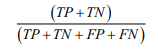

In [64]:
accuracy=float((tp+tn) / (results.count()))
print(accuracy)

0.9391619661563255


**Recall**

Recall rate shows how much of the positive class cases we are able to 
predict correctly out of the total positive class observations

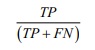

In [65]:
recall = float(tp)/(tp + fn)
print(recall)

0.9371245494593512


**Precision**

Precision rate talks about the number of true positives predicted 
correctly out of all the predicted positives observations:

In [67]:
precision = float(tp) / (tp + fp)
print(precision)

0.9416498993963782
